Independent variable
  - Rest length of the string $L$

Control variables
  - Mass of the lock: $200\mathrm{g}$
  - Center of mass of the lock from the top: $5\mathrm{cm}$
  - Air resistance of the lock $-kv^2$
  - String constraint $C(\Delta L) = Le^{\Delta L/L} - \Delta L$ for $\Delta L > 0$
    - String force $F_s(\Delta L) = -k_s C'(\Delta L)C(\Delta L)$
    - String damping $F_d(\Delta x) = -k_d C'(\Delta L) C'(\Delta L)\cdot v$
  - Movable frame constraint $C(r) = |r|^2$
    - Moveable frame force $F_s(r) = -k_s C'(r)C(r)$
    - Moveable frame damping $F_d(r) = -k_d C'(r) C'(r)\cdot v$



Adjust control variables to fit experimental data.

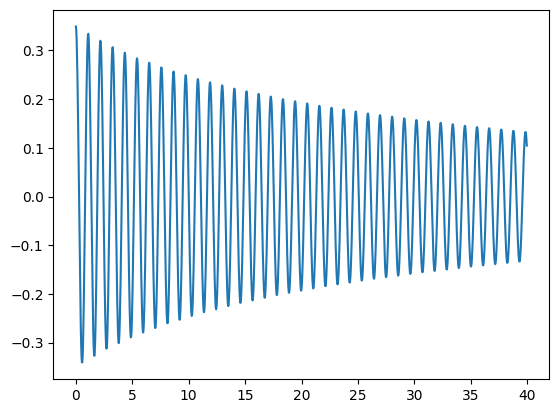

In [1]:
from math import *
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt

g = 9.81
M = 0.2  # mass of the lock
Lm = 0.05  # center of mass of the lock
L = 0.20

def func(u, t):
    mx, my, mz, fdx, fdy, vx, vy, vz, fvx, fvy = u
    x = np.array([mx, my, mz])
    fx = np.array([fdx, fdy, 0])
    v = np.array([vx, vy, vz])
    fv = np.array([fvx, fvy, 0])
    a = np.array([0.0, 0.0, -g])
    fa = np.array([0.0, 0.0, 0.0])

    # air resistance
    a -= 0.004 * np.linalg.norm(v) * v / M

    # string constraint
    L1 = np.linalg.norm(x-fx)
    dL = L1-Lm - L
    if dL > 0:
        ks, kd = 300.0, 4000.0
        Cs = L * exp(dL/L) - dL
        dCs = (exp(dL) - 1.0) * (x-fx)/L1
        a -= ks * Cs * dCs / M
        a -= kd * dCs * np.dot(dCs, v) / M
        fa += ks * Cs * dCs
        fa += kd * dCs * np.dot(dCs, fv)

    # frame constraint
    r = np.linalg.norm(fx)
    if r != 0.0:
        # ks, kd = 2000000.0, 8000.0
        # Cs = r*r
        # dCs = 2*r * fx/r
        # fa -= ks * Cs * dCs
        # fa -= kd * dCs * np.dot(dCs, fv)
        k = 1.2
        ks, kd = 2000.0**k, 400.0
        Cs = r**k
        dCs = k*r**(k-1) * fx/r
        fa -= ks * Cs * dCs
        fa -= kd * dCs * np.dot(dCs, fv)

    return [vx, vy, vz, fvx, fvy, *a, *fa[:2]]


l0 = 1.03*L+Lm
a0 = 20 * pi/180
ts = np.arange(30*40) / 30
xs = scipy.integrate.odeint(func,
    [l0*sin(a0), 0, -l0*cos(a0), 0, 0, 0, 0, 0, 0, 0], ts)

#plt.plot(xs[:, 0], xs[:, 2])
#plt.plot(ts, np.hypot(xs[:, 0], xs[:, 2]))
plt.plot(ts, np.arctan2(xs[:, 0], -xs[:, 2]))
plt.show()

Analyze data

[ 0.32459182 40.56828787  1.07701769 -0.18767135] [1.13123932e-03 3.34000203e-01 3.81411919e-05 3.56698411e-03]
Period: 1.07702 ± 0.00004
Q factor: 236.7 ± 1.9


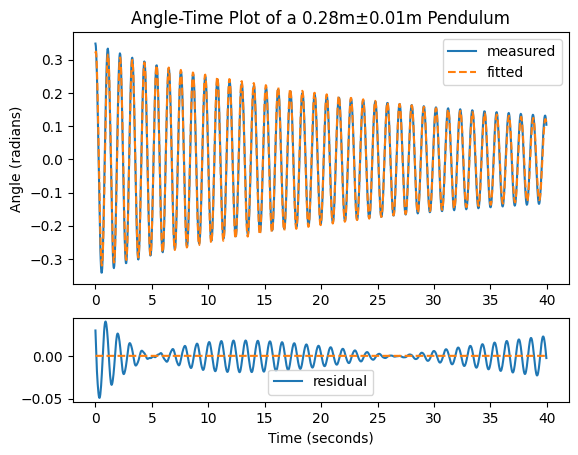

In [2]:
def damped(t, a0, tau):
    if tau < 0:
        return float('nan')
    return a0 * np.exp(-t/tau)
    # return a0 / (1.0 + t/tau)
    # return a0 / np.sqrt(1.0 + 2.0*t/tau)
    # return a0 / (1.0+0.5*t/tau)**2

def damped_harmonic(t, a0, tau, period, phase):
    a = damped(t, a0, tau)
    return a * np.cos(2.*np.pi*t/period + phase)

def fit_data(t, a, a_error, a0_guess=0.4, tau_guess=60.):
    init_guess = (a0_guess, tau_guess, 2.0*sqrt(L), 0.0)
    init_guess = scipy.optimize.curve_fit(
        damped_harmonic, t[:100], a[:100], p0=init_guess)[0]
    init_guess = scipy.optimize.curve_fit(
        damped_harmonic, t[:300], a[:300], p0=init_guess)[0]
    popt, popv = scipy.optimize.curve_fit(
        damped_harmonic, t, a,
        p0=init_guess, sigma=a_error*np.ones(len(a)))
    return popt, popv.diagonal()**0.5

def plot_angle_time_graph(l, l_error, t, a, params):
    a_pred = damped_harmonic(t, *params)
    residual = a - a_pred

    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

    ax1.set_title("Angle-Time Plot of a {:.2f}m±{:.2f}m Pendulum".format(l, l_error))
    ax2.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Angle (radians)")

    ax1.plot(t, a, '-')
    ax1.plot(t, a_pred, '--')
    ax1.legend(['measured', 'fitted'])

    ax2.plot(t, residual)
    ax2.legend(["residual"])
    ax2.plot(t, np.zeros(len(t)), '--')
    plt.show()

l = np.hypot(xs[:, 0], xs[:, 2])
l = np.mean(l)
l_error = sqrt(np.var(l) + 0.01**2)
a = np.arctan2(xs[:, 0], -xs[:, 2])
a -= np.mean(a)
a_error = 0.01 * np.maximum(abs(xs[:, 2]), abs(xs[:, 0])) / (xs[:, 0]**2 + xs[:, 2]**2)

params, perror = fit_data(ts, a, a_error)
print(params, perror)
print("Period: {:.5f} ± {:.5f}".format(params[2], perror[2]))

q = 2.0*np.pi * params[1] / params[2]
q_e = 2.0*np.pi * max(abs(perror[1] / params[2]), abs(perror[2] * params[1] / params[2]**2))
print("Q factor: {:.1f} ± {:.1f}".format(q, q_e))

plot_angle_time_graph(l, l_error, ts, a, params)

Run batch with uncertainties.

In [3]:
import random
random.seed(0)

def trig_distribution(center, spread):
    """Distribution of human error"""
    return center + spread * (random.random() + random.random() - 1)

def random_sphere(spread):
    u = 2.0*pi * random.random()
    v = 2.0*random.random()-1.0
    r = sqrt(1-v*v)
    n = np.array([r*cos(u), r*sin(u), v])
    return trig_distribution(0.0, spread) * n

def batch_pass(l0):
    global L, g
    L = l0

    g = 9.81 + 0.02*(random.random()-random.random())  # fake
    l0 = trig_distribution(1.03, 0.01) * L + Lm
    a0 = trig_distribution(20, 5) * pi/180
    ts = np.arange(40*30) / 30
    x0 = [l0*sin(a0), 0, -l0*cos(a0)] + random_sphere(0.005*l0)
    v0 = random_sphere(0.005*l0)
    xs = scipy.integrate.odeint(func, [*x0, 0, 0, *v0, 0, 0], ts)
    time_clip = int(abs(trig_distribution(0, 2.0*30)))
    ts, xs = ts[time_clip:], xs[time_clip:]

    l = np.hypot(xs[:, 0], xs[:, 2])
    l, l_error = np.mean(l), sqrt(np.var(l))
    a = np.arctan2(xs[:, 0], -xs[:, 2])
    a -= np.mean(a)
    a_error = 0.01 * np.maximum(abs(xs[:, 2]), abs(xs[:, 0])) / (xs[:, 0]**2 + xs[:, 2]**2)

    params, perror = fit_data(ts, a, a_error)
    print(params, perror)
    print("Period: {:.5f} ± {:.5f}".format(params[2], perror[2]))

    q = 2.0*np.pi * params[1] / params[2]
    q_e = 2.0*np.pi * max(abs(perror[1] / params[2]), abs(perror[2] * params[1] / params[2]**2))
    print("Q factor: {:.1f} ± {:.1f}".format(q, q_e))

    # plot_angle_time_graph(l, l_error, ts, a, params)

    return {
        't': ts,
        'l': l,
        'l_error': l_error,
        'a': a,
        'a_error': a_error,
        'T': params[2],
        'T_error': perror[2],
        'q': q,
        'q_error': q_e
    }

ls = []
les = []
Ts = []
Tes = []
qs = []
qes = []
for l0 in [0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2]:
    params = batch_pass(l0)
    ls.append(params['l'])
    les.append(params['l_error'])
    Ts.append(params['T'])
    Tes.append(params['T_error'])
    qs.append(params['q'])
    qes.append(params['q_error'])


[ 0.31966961 43.15983802  1.0770218  -0.18344909] [1.06925626e-03 3.52423499e-01 3.51804242e-05 3.36463610e-03]
Period: 1.07702 ± 0.00004
Q factor: 251.8 ± 2.1
[ 0.33494768 59.78221855  1.1589654  -0.17132202] [1.13938473e-03 6.30331192e-01 3.79753671e-05 3.44040955e-03]
Period: 1.15897 ± 0.00004
Q factor: 324.1 ± 3.4
[ 0.35359409 77.15251145  1.23859794 -0.1352892 ] [1.00248426e-03 8.43213411e-01 3.54145551e-05 2.92904426e-03]
Period: 1.23860 ± 0.00004
Q factor: 391.4 ± 4.3
[ 2.96060535e-01  1.12422761e+02  1.31139635e+00 -6.65973464e-02] [4.32871795e-04 8.68511582e-01 1.91873165e-05 1.50227905e-03]
Period: 1.31140 ± 0.00002
Q factor: 538.6 ± 4.2
[ 3.33498595e-01  1.25192026e+02  1.38389576e+00 -7.24512848e-02] [5.26589148e-04 1.14409928e+00 2.23499539e-05 1.59437434e-03]
Period: 1.38390 ± 0.00002
Q factor: 568.4 ± 5.2
[ 3.46221913e-01  1.24094674e+02  1.51969428e+00 -6.74859157e-02] [4.68071512e-04 9.57121183e-01 2.29969989e-05 1.36459427e-03]
Period: 1.51969 ± 0.00002
Q factor: 513.

Period vs. Length

[2.01928887 0.49563714] [0.00051488 0.00046282]


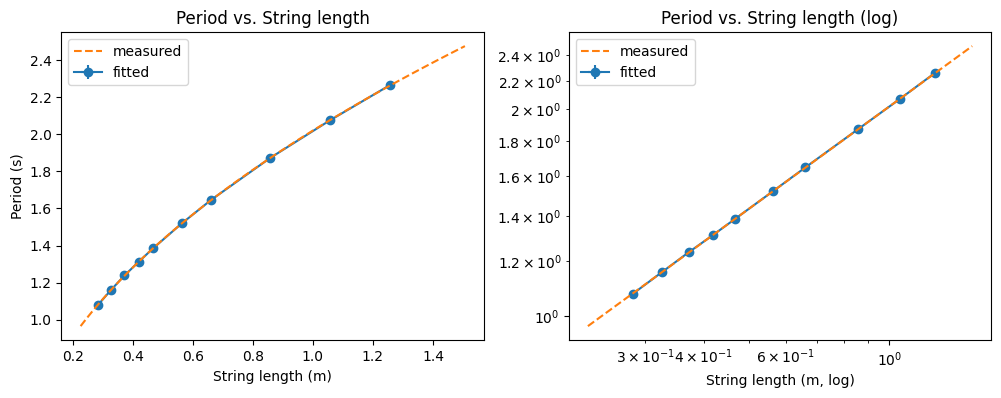

In [4]:
def power_fun(x, a, k):
    return a * x**k

params, popv = scipy.optimize.curve_fit(
    power_fun, ls, Ts,
    p0=(2, 0.5), sigma=Tes)
print(params, popv.diagonal()**0.5)

xp = np.linspace(0.8*ls[0], 1.2*ls[-1], 100)
yp = power_fun(xp, *params)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title("Period vs. String length")
ax1.set_xlabel("String length (m)")
ax1.set_ylabel("Period (s)")
ax1.errorbar(ls, Ts, xerr=les, yerr=Tes, fmt="o-", zorder=0)
ax1.plot(xp, yp, "--")
ax1.legend(["measured", "fitted"])

ax2.set_title("Period vs. String length (log)")
ax2.set_xlabel("String length (m, log)")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.errorbar(ls, Ts, xerr=les, yerr=Tes, fmt="o-", zorder=0)
ax2.plot(xp, yp, "--")
ax2.legend(["measured", "fitted"])

plt.show()


Q factor vs. Length

[1.11960109e+04 2.02197074e+00 3.31795658e+00] [1.15823146e+04 6.82845712e-01 1.07027898e+00]


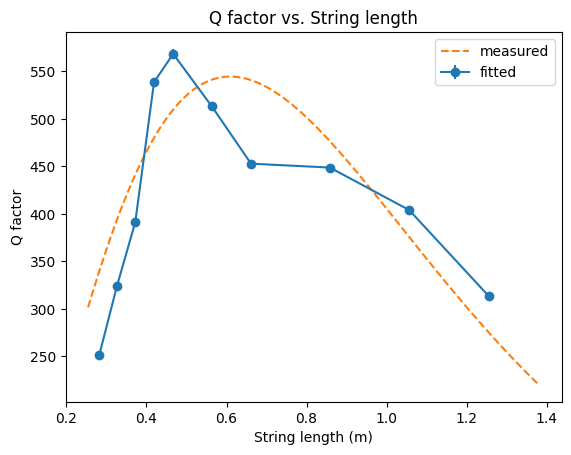

In [13]:
def fit_fun(x, a, k, b):
    return a * x**k * np.exp(-b*x)

params, popv = scipy.optimize.curve_fit(
    fit_fun, ls, qs,
    p0=(500, 0.5, 4.0), sigma=Tes)
print(params, popv.diagonal()**0.5)

xp = np.linspace(ls[0], ls[-1], 100)
yp = fit_fun(xp, *params)

plt.title("Q factor vs. String length")
plt.xlabel("String length (m)")
plt.ylabel("Q factor")
plt.errorbar(ls, qs, xerr=les, yerr=qes, fmt="o-")
plt.plot(xp, yp, "--")
plt.legend(["measured", "fitted"])
plt.show()